<img src="https://cdn.pixabay.com/photo/2018/02/19/20/29/divider-3166173__340.png" width="600" align="center"> 

<h1 style="font-size:40px; font-family:Courier New"><center>Comprehensive <br/> Exploratory Data Analysis</center></h1>

<h3 style="font-size:16px; "><center>BY ANDREAS PALMGREN</center></h3>


<img src="http://www.clker.com/cliparts/Q/4/8/p/B/p/black-divider-hi.png" width="500" align="center"> 


> **Exploratory data analysis is the work of a detective. Understanding the possibilities of your data is the first step in laying the groundwork for future modeling. With this notebook, we try to make sense of our data and demonstrate how data can be analyzed. We'll look for trends, limitations, and other characteristics linked to the questions we're interested in as part of our investigation.**

<h1 style="font-size:35px; font-family:Courier New">1. Data source</h1>

> **Google and X, the moonshot factory, have supplied the dataset, which contains about 160 000 Jupyter notebooks. This is part of a <a href="https://www.kaggle.com/competitions/AI4Code">Kaggle competition</a> to train a model that can rank markdown cells depending on the order of its code cells. Code cells are written in python and markdown cells are written in markdown, which is the text formatting langague used in Jupyter.**

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from tqdm import tqdm
from pathlib import Path
import re
import os

pd.options.display.width = 180
pd.options.display.max_colwidth = 100

data_dir = Path("../input/AI4Code")

rc = {"axes.spines.left" : True,
      "axes.spines.right" : False,
      "axes.spines.bottom" : True,
      "axes.spines.top" : False,
      "xtick.bottom" : True,
      "xtick.labelbottom" : True,
      "ytick.labelleft" : True,
      "ytick.left" : True,
      "figure.subplot.hspace" : 0.7,
    "figure.titleweight" : "bold",
    "axes.titleweight" : "bold",
     "font.weight" : "bold"}
plt.rcParams.update(rc)

In [4]:
def read_notebook(path):
    return (
        pd.read_json(
            path,
            dtype={'cell_type': 'category', 'source': 'str'})
        .assign(id=path.stem)
        .rename_axis('cell_id')
    )

# Subset of training due to its large size
NUM_TRAIN = 20000
paths_train = list((data_dir / 'train').glob('*.json'))[:NUM_TRAIN]
#paths_train = list((data_dir / 'train').glob('*.json'))

notebooks_train = [read_notebook(path) for path in tqdm(paths_train, desc='Train NBs')]

# Get notebooks
df_notebooks = (pd.concat(notebooks_train).set_index('id', append=True).swaplevel().sort_index(level='id', 
                                                                                               sort_remaining=False)) 

# Get correct order of cells in notebooks                                                                                          
df_orders = pd.read_csv(data_dir/'train_orders.csv', index_col='id')
df_orders = df_orders.squeeze().str.split(" ").explode().to_frame()
df_orders["rank"] = pd.Series([np.arange(x) for x in df_orders.groupby("id").count()["cell_order"]]).explode().to_numpy()

df = df_notebooks.reset_index().merge(df_orders.reset_index().rename(columns = {'cell_order':'cell_id'}), 
                       how='inner', on=['id','cell_id'])

# Get ancestors for notebooks
df_ancestors = pd.read_csv(data_dir / 'train_ancestors.csv', index_col='id')

# Final combined dataframe
df = df.merge(df_ancestors, on="id").sort_values(["id", "rank"]).set_index(["id", "cell_id"])


# Dataframe for count information - Used in EDA
mkd = df[df["cell_type"] == "markdown"].groupby(by=["id"]).count().source
code = df[df["cell_type"] == "code"].groupby(by=["id"]).count().source
df_counts = pd.concat([mkd, code], axis=1)
df_counts.columns = ['markdown_count', 'code_count']
df_counts["tot"] = df_counts.markdown_count+df_counts.code_count
df_counts["ratio"] = df_counts.code_count / df_counts.tot

Train NBs: 100%|██████████| 20000/20000 [04:17<00:00, 77.77it/s]


<div class="alert alert-block alert-info">
<b>Tip:</b> csv-files are slow. I would recommend saving the dataframe as a parquet file (pandas.DataFrame.to_parquet). In my own testing, reading the pre-prepared parquet file  is ~150 times faster than reading all csv-files and creating the combined dataframe. </div>

>**Training data consists out of 140 000 JSON files, each containing a notebook where markdown cells have been shuffeled. Additional files regarding correct markdown order, as well as, information of "forked notebook" has also been given. Following table is a combination of all given training files, including the correct order and ancestor_id/parent_id.**

>> * **`id` - Unique identification of notebook.** 
>>* **`cell_id` - Unique identification of cell within notebooks.** 
>>* **`cell_type` - Factor specifying cell type, either being a code cell or markdown cell.** 
>>* **`source` - String with content of cell.**
>>* **`rank` - Order rank for given cell within notebook.**
>>* **`ancestor_id` - Identifies sets of notebooks with common origin.**
>>* **`parent_id` - Some version of the notebook id was forked from some version of the notebook `parent_id`. It may or may not be present (i.e. `parent_id` may be missing due to someone having forked a private notebook).** 

In [5]:
df.head()

cell_type                                                                                               source rank ancestor_id parent_id
id             cell_id                                                                                                                                           
0001bdd4021779 3fdc37be      code  import pandas as pd\nimport numpy as np \nimport matplotlib.pyplot as plt\nimport seaborn as sns...    0    a7711fde       NaN
               073782ca      code                                  df = pd.read_csv("/kaggle/input/us-police-shootings/shootings.csv")    1    a7711fde       NaN
               8ea7263c      code                                                                                            df.head()    2    a7711fde       NaN
               80543cd8      code                                                                                      df.isna().sum()    3    a7711fde       NaN
               38310c80      code       sns.set()\nsns.countplot(df["gender"])\nplt.title("The Gender of Killed Person")\nplt.show()\n    4    a7711fde       NaN

> **We're in luck because the competition organizers have already cleaned the dataset. It has been stated that:** 
>>* **Notebooks contain at least one of each `cell_type`, meaning notebooks should have a length of 2 or more.** 
>>- **Any cells with empty `source` have already have been removed.**  
>>- **All code is written in python.** 

> **Before continuing with the analysis, we need to make a short check on our own. `cell_type` is a factor that specifies one of two cell types: markdown or code. Only these two types appear to be present in the data, which is good.**

In [6]:
df["cell_type"].unique()

array(['code', 'markdown'], dtype=object)

> **We should not have any missing values, excpet within `parent_id`. Since the data appears to be clean, it is time to start our analysis.**

In [7]:
df.isna().sum()

cell_type           0
source              0
rank                0
ancestor_id         0
parent_id      806655
dtype: int64

<img src="http://www.clker.com/cliparts/Q/4/8/p/B/p/black-divider-hi.png" width="500" align="center"> 


<h1 style="font-size:35px; font-family:Courier New">2. Analysis</h1>

> **Analysis will be based on a subset of the training data (20 000 notebooks).**

<h2 style="font-size:25px; font-family:Courier New">2.1 Code vs. Markdown</h2>

> **We now possess enough information to begin our analysis. Due to the fact that our model aims to order markdown cells based on code cells, the relationship between the two is of primary importance. A great starting point is to display the proportion of cell types across all notebooks. As seen in the pie chart below, code cells appear to be far more common than markdown cells which give us plenty to work on.**

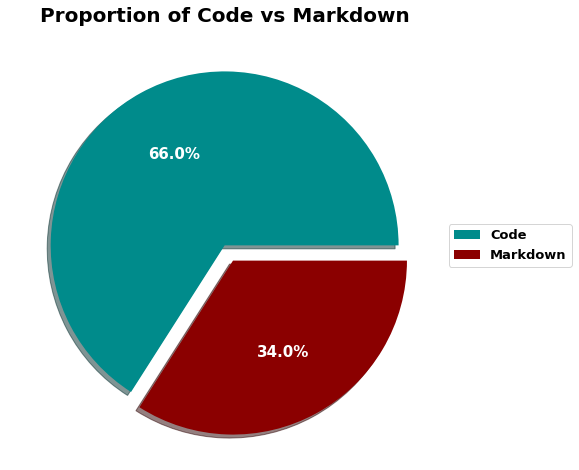

In [8]:
fig1, ax = plt.subplots(figsize=(8,8))
wedges, texts, autotexts = ax.pie([df_counts.code_count.sum(), df_counts.markdown_count.sum()], shadow=True, 
                                  explode=(0, 0.1), labels=["Code", "Markdown"], 
                                  autopct='%1.1f%%', textprops=dict(color="w"), colors=["#008b8b", "#8b0000"])

plt.setp(autotexts, size=15, weight="bold")
ax.legend(wedges, ["Code", "Markdown"],
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1), prop={'size': 13})

ax.set_title("Proportion of Code vs Markdown", size=20);

> **Another intuitive plot is the number of cells in a notebook as a measure of its length. The histogram below displays the sample distribution for notebook lengths and it appears to be right-skewed. The average notebook contains 30-40 cells, whereas some notebooks contain a couple hundred.**

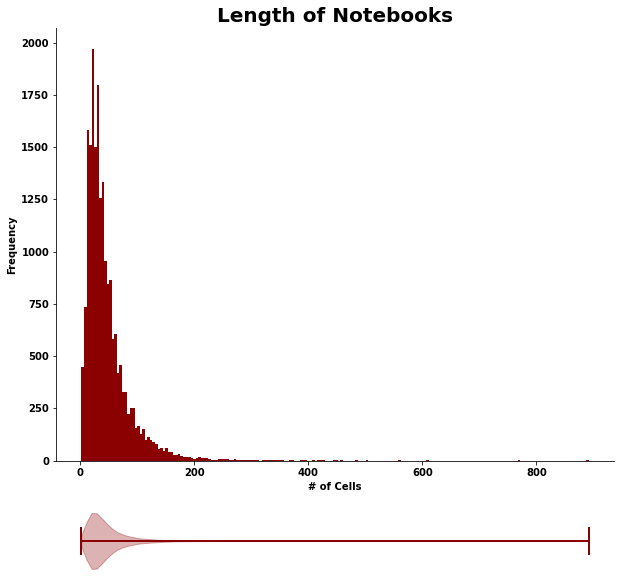

In [9]:
fig, axs = plt.subplots(2, figsize=(10,10), gridspec_kw={"height_ratios": [7, 1]})
fig.subplots_adjust(hspace=0.2)

count = df.groupby(by=["id"]).count()["source"].values
axs[0].hist(count, bins=200, color="#8b0000")

axs[0].set_xlabel("# of Cells", weight="bold")
axs[0].set_ylabel("Frequency", weight="bold")
axs[0].set_title(f"Length of Notebooks", size=20);

violin_parts = axs[1].violinplot(count, vert=False);
for part in violin_parts['bodies']:
    part.set_facecolor("#8b0000")
    part.set_edgecolor("#8b0000")
    
for partname in ('cbars','cmins','cmaxes'):
    vp = violin_parts[partname]
    vp.set_edgecolor("#8b0000")
    vp.set_linewidth(2)

# Hide axis spine, ticks
for txt in ["top","right","left","bottom"]:
        axs[1].spines[txt].set_visible(False)
axs[1].xaxis.set_visible(False)
axs[1].yaxis.set_visible(False)

> **In our case, the central tendency is best described by the median.**

In [10]:
print(" \033[1m", "Median of Notebook lengths: ", np.median(count), "\033[0m")
print("\n \033[1m", "Most frequenct Notebook length: ", df_counts.tot.value_counts().idxmax(), "\033[0m")

  Median of Notebook lengths:  35.0 

  Most frequenct Notebook length:  21 


> **We can examine notebook length once more, but this time compare the sample distribution of code and markdown cells. A large spike for markdown cells can be seen in the ridge plot below.**  

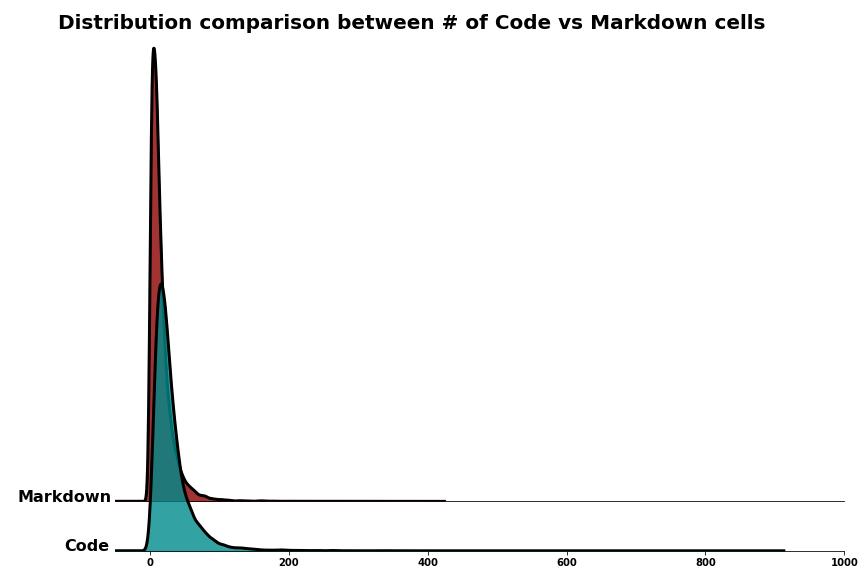

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10), gridspec_kw={'width_ratios': [1, 7]})
fig.subplots_adjust(wspace=0.01, hspace=-0.9)

colors=["#8b0000", "#008b8b"]
for i, df_count in enumerate([df_counts.markdown_count, df_counts.code_count]):
    
    kde = df_count.plot.kde(ax = axs[i,1], color="black", bw_method=0.15, lw=3)
    
    # Fill
    x = kde.get_children()[0]._x
    y = kde.get_children()[0]._y
    axs[i,1].fill_between(x, y, color=colors[i], alpha=0.8)
    
    rect = axs[i, 1].patch
    rect.set_alpha(0)
    
    # Uniform axes
    axs[i,1].set_xlim(-50, 1000)
    axs[i,1].set_ylim(0, 0.05)
    
    axs[i,1].yaxis.set_visible(False)
    
    
    for txt in ["top","right","left"]:
        axs[i,1].spines[txt].set_visible(False)
    
axs[0,1].tick_params(axis="x", which="both", colors = "#E2E2E2")
axs[0,1].xaxis.set_visible(False)

# remove the underlying axes and create one big
gs = axs[0, 0].get_gridspec()
for ax in axs[:, 0]:
    ax.remove()
ax = fig.add_subplot(gs[:, 0])
ax.set_ylim(0,2)
ax.text(0.1, 0.18, "Markdown", color = "black", size = 16, weight='bold')
ax.text(0.55, 0, "Code", color = "black", size = 16, weight='bold')

# Hide axis spine, ticks
for txt in ["top","right","left","bottom"]:
        ax.spines[txt].set_visible(False)
ax.yaxis.set_visible(False)
ax.xaxis.set_visible(False)

fig.suptitle('Distribution comparison between # of Code vs Markdown cells', size=20, y=0.87);

> **The skewed distributions are an important takeaway from the last distribution plots, and exploring the tails could reveal further information. The bar plot below displays the longest and shortest notebooks. We already know that notebooks should have at least two cells, and it appears as if we might have several 2-cell notebooks.**

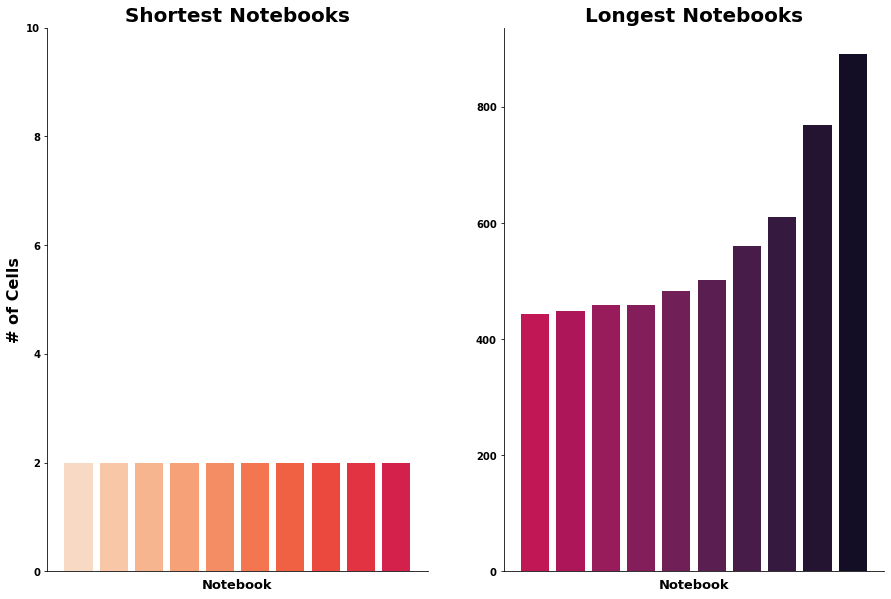

In [12]:
colors = sns.color_palette("rocket_r", n_colors=20)

fig, axs = plt.subplots(1,2, figsize=(15, 10))

count = df_counts.sort_values("tot").head(10).tot
axs[0].bar(range(10), count.values, color=colors[:10])
axs[0].set_ylim(0, 10)
axs[0].set_title("Shortest Notebooks", size=20)

count = df_counts.sort_values("tot").tail(10).tot
axs[1].bar(range(10), count.values, color=colors[10:])
axs[1].set_title("Longest Notebooks", size=20)

for i in range(2):
    axs[i].set_xlabel("Notebook", weight="bold", size=13)
    axs[i].set_xticks([])
    
axs[0].set_ylabel("# of Cells", weight="bold", size=16);

> **When looking at the content of a few of the 2-cell notebooks, it appears that the majority of them begin with a markdown cell before moving on to a code cell. The bar chart below confirms our findings after further examination. This raises the question of whether the most common cell type to start a notebook with is a markdown cell. As illustrated in the pie chart below, most notebooks begin with a markdown cell.**

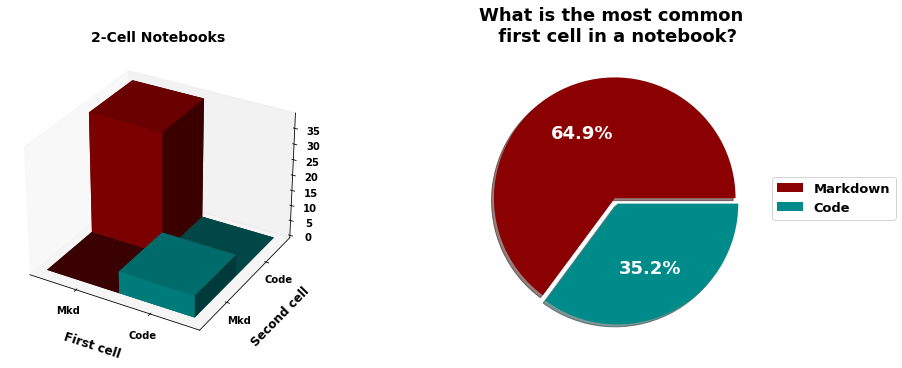

In [13]:
# Matrix for 2-cell notebooks
matrix = pd.DataFrame(data = np.zeros((2,2)), columns=["code", "markdown"], index=["code", "markdown"])
for notebook in df_counts[df_counts["tot"]==2].index:
    cell1 = df.loc[notebook].cell_type[0]
    cell2 = df.loc[notebook].cell_type[1]
    matrix.loc[cell1, cell2] = 1 + matrix.loc[cell1, cell2]

# setup the figure and axes
fig = plt.figure(figsize=(15, 15))
ax1 = fig.add_subplot(221, projection='3d')

# fake data
_x = np.arange(2)
_y = np.arange(2)
_xx, _yy = np.meshgrid(_x, _y)
x, y = _xx.ravel(), _yy.ravel()

top = x + y
bottom = np.zeros_like(top)
width = depth = 1

ax1.bar3d(x, y, bottom, width, depth, matrix.values.flatten(), shade=True, 
          color=["#6b0202", "#008b8b", "#8b0000", "#015c5c"])
ax1.set_title('2-Cell Notebooks', size=14)


ax1.grid(False)
ax1.set_xticks([0.5, 1.5])
ax1.set_yticks([0.5, 1.5])
ax1.set_yticklabels(["Mkd", "Code"])
ax1.set_xticklabels(["Mkd", "Code"])

ax1.set_xlabel("First cell", weight="bold", labelpad=10, size=12)
ax1.set_ylabel("Second cell", weight="bold", labelpad=10, size=12)

# Pie chart
ax2 = fig.add_subplot(222)
wedges, texts, autotexts = ax2.pie(df[df["rank"]==0]["cell_type"].value_counts(), shadow=True, 
                                  explode=(0, 0.05), 
                                  autopct='%1.1f%%', textprops=dict(color="w"), colors=["#8b0000", "#008b8b"])
plt.setp(autotexts, size=18, weight="bold")

ax2.legend(wedges, ["Markdown", "Code"],
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1), prop={'size': 13})

ax2.set_title("What is the most common \n first cell in a notebook?", size=18);

<div class="alert alert-block alert-info">
<b>Note:</b> The three-dimensional bar graph illustrates how no two-cell notebook starts and ends with the same cell type. This is to be expected, given that every notebook should have at least one of each type of cell. </div>

> **We have a decent understanding of how our 2-cell notebooks look, but checking all lengths would be impracticable. Instead, we can examine the most common notebook length in greater detail. The figure below depicts the distribution of cell types for each cell in notebooks of the most common length. Markdowns are dominant in the first cell, as we can see. This ratio can be compared to the pie chart above, which depicts the most common cell in all notebooks. Except for the first, all cells are dominated by code cells.**

>**The alternating pattern is a crucial takeaway since it appears the chances of succeeding code cells are decreasing.**

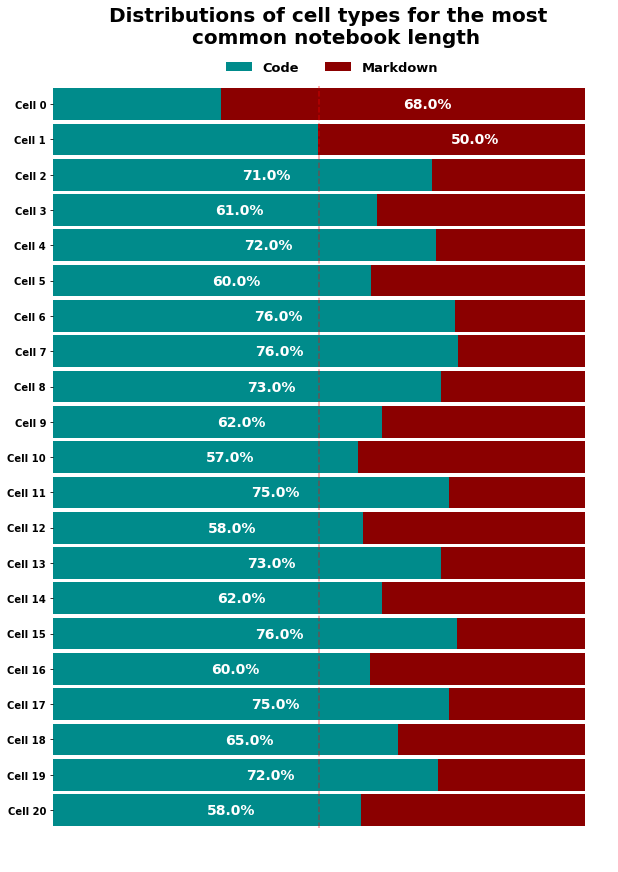

In [14]:
most_freq_length = df_counts.tot.value_counts().idxmax()
count_cells = pd.DataFrame(np.zeros((2, most_freq_length)), index=["code", "markdown"])

# Grab all notebooks of average length and look at rank for types
for notebook in df_counts[df_counts.tot == most_freq_length].index:
    
    dt = df.loc[notebook, ["cell_type", "rank"]]
    count_cells.loc["code"] = count_cells.loc["code"].to_numpy() + [dt.cell_type == "code"]
    count_cells.loc["markdown"] = count_cells.loc["markdown"].to_numpy() + [dt.cell_type == "markdown"]

cell_ratios = count_cells / np.sum(count_cells, axis=0)


# -- Plot
fig, ax = plt.subplots(1, figsize=(10, 15))

ax.barh(range(most_freq_length), np.flip(cell_ratios.loc["code"]), height=0.9, color="#008b8b", label="Code")
ax.barh(range(most_freq_length), np.flip(cell_ratios.loc["markdown"]), left=np.flip(cell_ratios.iloc[0]), 
         height=0.9, color="#8b0000", label="Markdown")

ax.set_yticks(range(21))
ax.set_yticklabels(np.flip([f"Cell {x}" for x in range(21)]));

ax.set_title("Distributions of cell types for the most \n common notebook length", size=20)
ax.legend(loc="upper center", frameon=False, prop={'size': 13}, ncol=2)

ax.plot(np.ones(most_freq_length+1)*0.5, np.arange(-0.5, most_freq_length+0.5, 1), linestyle="--", c="r", alpha=0.4)

for i in range(most_freq_length):
    
    dt_code = cell_ratios.loc["code"][most_freq_length-1-i]
    dt_mkd = cell_ratios.loc["markdown"][most_freq_length-1-i]
    
    if dt_code>dt_mkd:
        ax.annotate(f"{np.round(dt_code*100)}%", (dt_code/2, i-0.12), c="w", size=14)
    else:
        ax.annotate(f"{np.round(dt_mkd*100)}%", (dt_code + dt_mkd/2, i-0.12), c="w", size=14)

# Hide axis spine, ticks
for txt in ["top","right","left","bottom"]:
        ax.spines[txt].set_visible(False)
ax.xaxis.set_visible(False)

<img src="http://www.clker.com/cliparts/Q/4/8/p/B/p/black-divider-hi.png" width="500" align="center"> 

> **We're starting to get a better grasp on the data we're dealing with, but we must never lose sight of our main goal. The relationship between code and markdown cells has to be looked into more thoroughly. Our investigation began with a pie chart of code vs. markdown cells, which we may analyze further with a histogram. The sample distribution below depicts the ratio code cells in notebooks. Only a few notebooks appear to be dominated by markdown cells, whereas many appear to be dominated by code cells.**

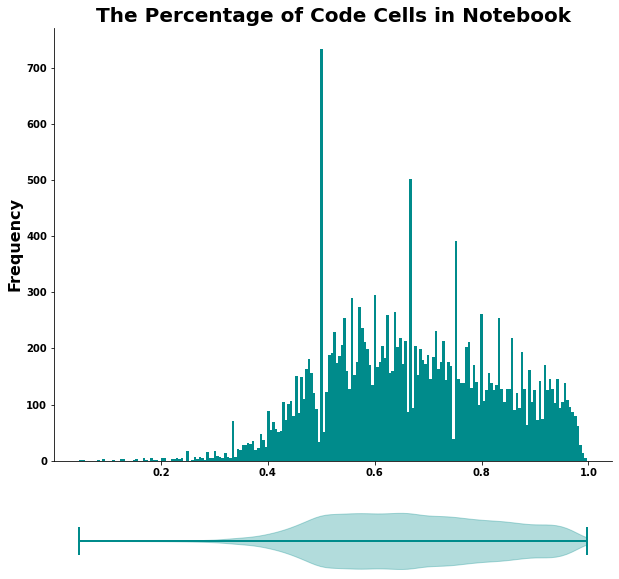

In [15]:
ratio = df_counts.sort_values("ratio", ascending=False).ratio

fig, axs = plt.subplots(2, figsize=(10,10), gridspec_kw={"height_ratios": [7, 1]})
fig.subplots_adjust(hspace=0.2)

# Histogram
axs[0].hist(ratio, bins=200, color="#008b8b");
axs[0].set_title("The Percentage of Code Cells in Notebook", size=20)
axs[0].set_ylabel("Frequency", weight="bold", size=16)

# Violin
violin_parts = axs[1].violinplot(ratio, vert=False);
for part in violin_parts['bodies']:
    part.set_facecolor("#008b8b")
    part.set_edgecolor("#008b8b")
    
for partname in ('cbars','cmins','cmaxes'):
    vp = violin_parts[partname]
    vp.set_edgecolor("#008b8b")
    vp.set_linewidth(2)

# Hide axis spine, ticks
for txt in ["top","right","left","bottom"]:
        axs[1].spines[txt].set_visible(False)
axs[1].xaxis.set_visible(False)
axs[1].yaxis.set_visible(False)

>**We could look into the proportion of different cell types in more detail. Only very short notebooks are dominated by markdown cells, as shown in the scatter plot. It also demonstrates how code cells can dominate in longer notebooks.**

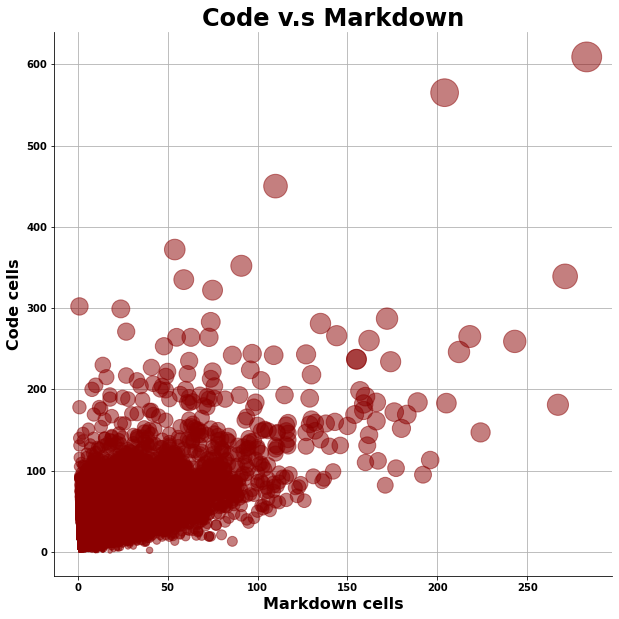

In [16]:
fig, ax = plt.subplots(1, figsize=(10,10))
ax.scatter(df_counts.markdown_count, df_counts.code_count, s=df_counts.tot, c="#8b0000", zorder=3, alpha=0.5)

ax.set_xlabel("Markdown cells", size=16, weight="bold")
ax.set_ylabel("Code cells", size=16, weight="bold")
ax.grid(zorder=0)
ax.set_title("Code v.s Markdown", size=24);

> **The ratio of code cells to notebook length can also be visualized. The same information can be extracted as from the previous one, but it’s clearer in this one how markdown cells only dominate in shorter notebooks.**

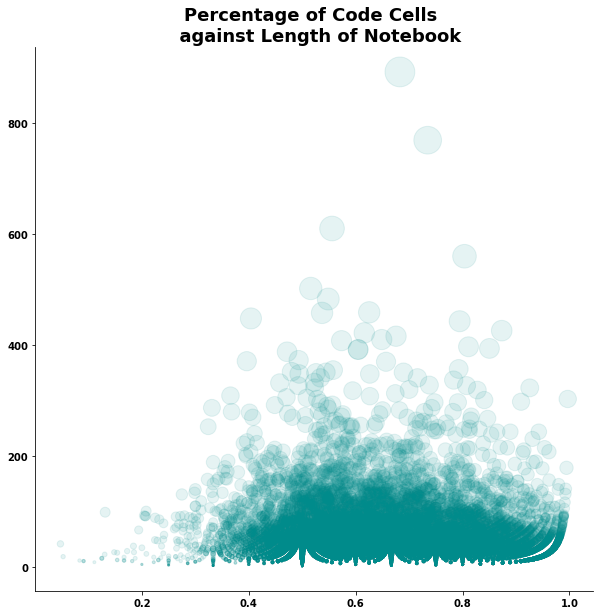

In [17]:
fig, ax = plt.subplots(1, figsize=(10,10))
tot = df_counts.sort_values("ratio", ascending=False).tot
ax.scatter(ratio, tot, s=tot, alpha=0.1, color="#008b8b")
ax.set_title("Percentage of Code Cells \n  against Length of Notebook", size=18);

<img src="http://www.clker.com/cliparts/Q/4/8/p/B/p/black-divider-hi.png" width="500" align="center"> 

<h2 style="font-size:25px; font-family:Courier New">2.2 A study of length</h2>

> **We've only looked at the count between cell types thus far. We can also compare their substance, starting with the number of characters in each. The figure below is a boxplot, however, the outliers make it difficult to tell. There are a few exceptionally lengthy cells in both types, but particularly in markdown.** 

In [18]:
# Add length to df
df["length"] = [len(x) for x in df.source]

# Add length to count df
df_counts["avg_len"] = df.groupby("id").mean("length")
df_counts["avg_len_code"] = df[df.cell_type == "code"].groupby("id").mean("length")
df_counts["avg_len_mkd"] = df[df.cell_type == "markdown"].groupby("id").mean("length")

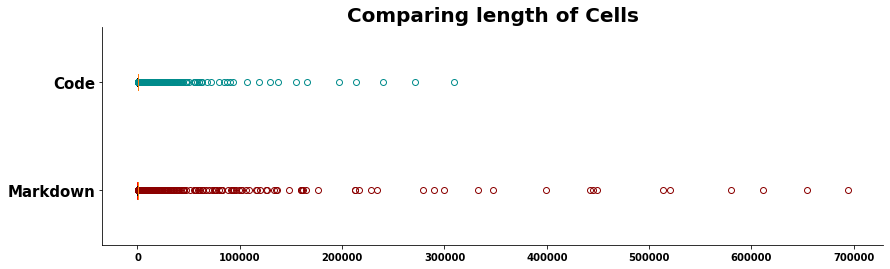

In [19]:
# For plot
code_length =  df[df["cell_type"]=="code"].sort_values("length", ascending=False).length.values
mkd_length =  df[df["cell_type"]=="markdown"].sort_values("length", ascending=False).length.values

fig, axs = plt.subplots(1, figsize=(14, 4))

axs.boxplot(code_length, positions=[2], vert=False, patch_artist=True, boxprops=dict(facecolor="red", color="red"),
             flierprops=dict(markeredgecolor="#008b8b"))
axs.set_title("Comparing length of Cells", size = 20)


box = axs.boxplot(mkd_length, positions=[1], vert=False, patch_artist=True, boxprops=dict(facecolor="red", color="red"),
             flierprops=dict(markeredgecolor="#8b0000"));

axs.set_yticks([1, 2], ["Markdown", "Code"], size=15);

> **As the limits are modified, the boxplot becomes more obvious. On average, markdown cells appear to be shorter than code cells.**

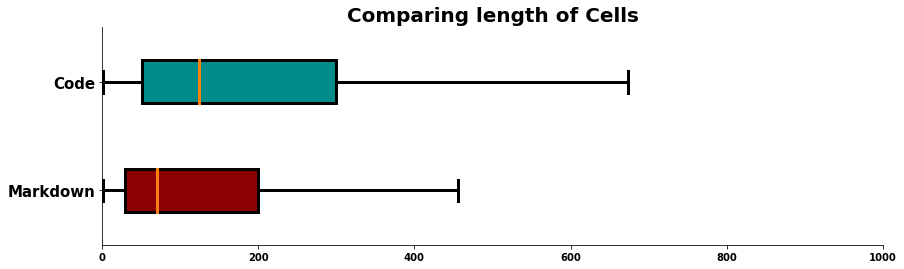

In [20]:
# Same plot as above but limited x-range to (0, 1000)

code_length =  df[df["cell_type"]=="code"].sort_values("length", ascending=False).length.values
mkd_length =  df[df["cell_type"]=="markdown"].sort_values("length", ascending=False).length.values

fig, axs = plt.subplots(1, figsize=(14, 4))

bplot1 = axs.boxplot(code_length, positions=[2], vert=False, patch_artist=True, widths= 0.4, 
                     boxprops=dict(facecolor="#008b8b", color="black", linewidth=3),
                     capprops=dict(linestyle='-', linewidth=3),
                     whiskerprops=dict(linestyle='-', linewidth=3),
                     medianprops=dict(linestyle='-', linewidth=3), showfliers=False)

bplot2 = axs.boxplot(mkd_length, positions=[1], vert=False, patch_artist=True, widths= 0.4, 
                     boxprops=dict(facecolor="#8b0000", color="black", linewidth=3),
                     capprops=dict(linestyle='-', linewidth=3),
                     whiskerprops=dict(linestyle='-', linewidth=3),
                     medianprops=dict(linestyle='-', linewidth=3), showfliers=False)

axs.set_xlim(0, 1000)
axs.set_yticks([1, 2], ["Markdown", "Code"], size=15)
axs.set_title("Comparing length of Cells", size = 20);

> **One reason for having longer cells could be there aren't as many of them overall. The scatterplot below looks at if there's a link between notebook length and average cell length. The graphic backs up our theory, with the longer cells showing up in the shorter notebooks.**

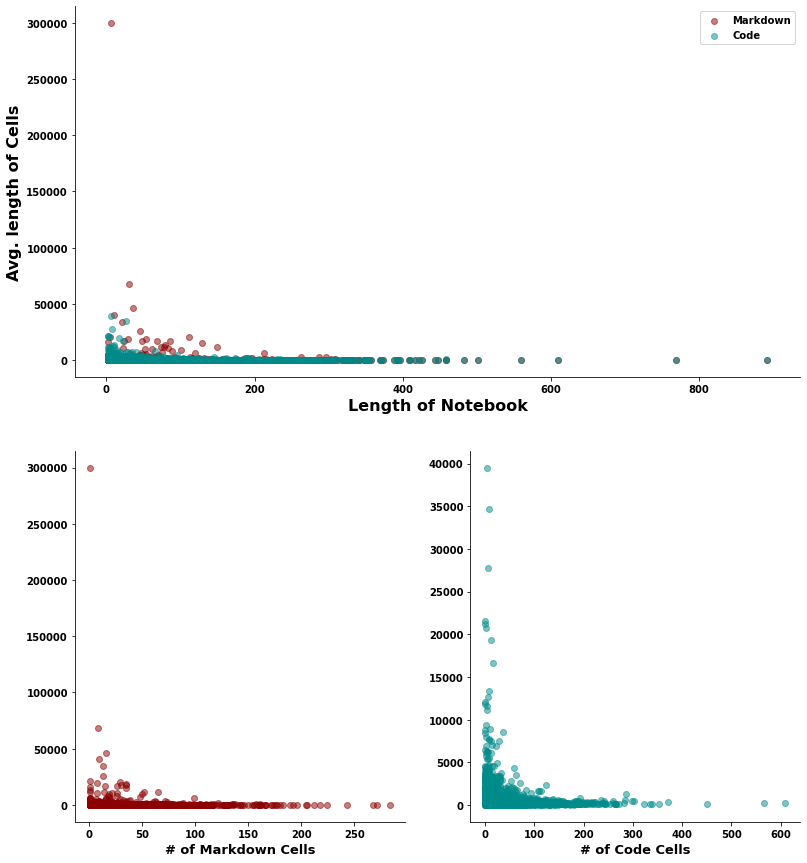

In [21]:
#dt = pd.merge(df_counts, df.groupby("id").mean("length"), on="id")

fig = plt.figure(figsize=(13,15))
fig.subplots_adjust(hspace=0.2)
spec = fig.add_gridspec(2, 2)

ax0 = fig.add_subplot(spec[0, :])
ax0.scatter(df_counts.tot, df_counts.avg_len_mkd, c="#8b0000", zorder=3, alpha=0.5, label="Markdown")
ax0.scatter(df_counts.tot, df_counts.avg_len_code, c="#008b8b", zorder=3, alpha=0.5, label="Code")
ax0.set_xlabel("Length of Notebook", size=16, weight="bold")
ax0.set_ylabel("Avg. length of Cells", size=16, weight="bold")
ax0.legend()

ax1 = fig.add_subplot(spec[1, 0])
ax1.scatter(df_counts.markdown_count, df_counts.avg_len_mkd, c="#8b0000", zorder=3, alpha=0.5)
ax1.set_xlabel("# of Markdown Cells", size=13, weight="bold")

ax2 = fig.add_subplot(spec[1, 1])
ax2.scatter(df_counts.code_count, df_counts.avg_len_code, c="#008b8b", zorder=3, alpha=0.5)
ax2.set_xlabel("# of Code Cells", size=13, weight="bold");

> **What exactly are these extra-long markdown cells? Closer analysis reveals most are due to image links, which explains the enormous number of characters.**

In [22]:
print("\033[1m"+"The first 100 characters of the markdown cell with the most characters: \n \n"+"\033[0m", 
      df.sort_values("length", ascending=False).source[0][:100])

The first 100 characters of the markdown cell with the most characters: 
 
 ![](data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAIFsAAAM9CAYAAAB174CUAAAgAElEQVR4XuzdT4gc+Xk//qdOoU


<img src="http://www.clker.com/cliparts/Q/4/8/p/B/p/black-divider-hi.png" width="500" align="center"> 

> **Let's bring back the notebook of most frequent length. We can look at whether there is a link between cell position and length. The median length of all positions is roughly similar, as seen in the graph below. The noticeable shifts in variation are far more interesting. The first position, as well as some of the more centered cells, have a lot of variation.**

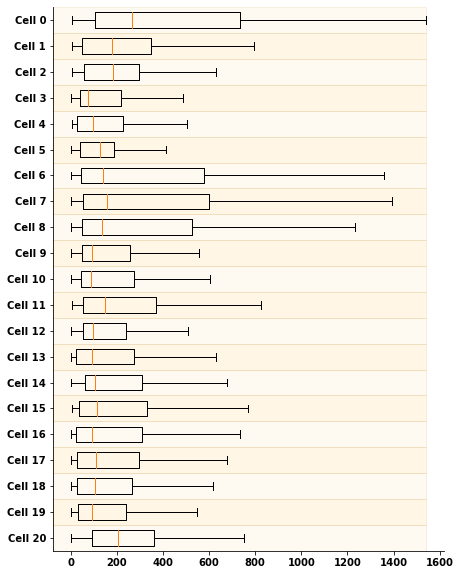

In [23]:
most_freq_length = df_counts.tot.value_counts().idxmax()
n = len(df_counts[df_counts.tot == most_freq_length].index)

avg_len_cells = pd.DataFrame(np.zeros((n, most_freq_length)))
avg_len_code = np.zeros((n, most_freq_length))
avg_len_mkd = np.zeros((n, most_freq_length))

# Grab all notebooks of average length and look at rank for types
for i, notebook in enumerate(df_counts[df_counts.tot == most_freq_length].index):
    
    dt = df.loc[notebook, ["cell_type", "length"]]
    avg_len_cells.iloc[i,:] = dt.length
    
    avg_len_code[i,:] = (dt["cell_type"]=="code")*dt.length
    avg_len_mkd[i,:] =(dt["cell_type"]=="markdown")*dt.length

fig, ax = plt.subplots(1, figsize=(7,10))

ax.boxplot(np.flip(avg_len_cells.values, axis=1), widths=0.6, vert=False, showfliers=False)

ax.set_yticks(range(most_freq_length+1))

ylabels = np.flip([f"Cell {x}" for x in range(most_freq_length+1)])
ylabels[0] = ""
ax.set_yticklabels(ylabels);
x_lim = ax.get_xlim()

ax.set_ylim((0.5, most_freq_length+0.5))

for i in range(most_freq_length):
    rect = patches.Rectangle((x_lim[0], i+0.5), x_lim[1], 1, linewidth=1, edgecolor="#B37B00", 
                             facecolor=["#FFD477", "#FFAF00"][i%2], zorder=0, alpha=0.1)
    ax.add_patch(rect)

>**We can go even further by considering `cell_type`. Between markdown and code cells, the deviation for position zero is roughly equal. In comparison to code cells, however, the middle positions show significantly less markdown variance.**

> **We should reason about why this is the case. One idéa is how notebooks often start with longer introductions and explanations, and move on to utilizing code cells. It appears that variation increases for markdown in the last positions, which could be explained by the author's giving a final conclusion.**

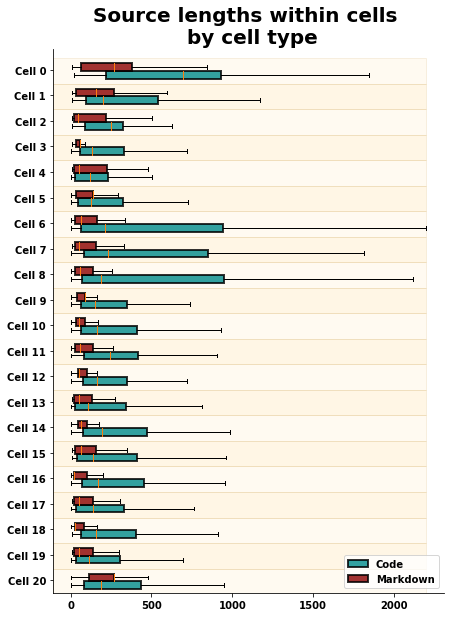

In [24]:
fig, ax = plt.subplots(1, figsize=(7,10))

bp1 = ax.boxplot([x[x != 0] for x in np.flip(avg_len_code, axis=1).T], widths=0.6, positions=np.arange(21)*2, vert=False, 
           patch_artist=True, showfliers=False, boxprops=dict(facecolor="#008b8b", color="black", linewidth=2, alpha=0.8),
           zorder=3)

bp2 = ax.boxplot([x[x != 0] for x in np.flip(avg_len_mkd, axis=1).T],  widths=0.6, positions=np.arange(21)*2+0.6, vert=False, 
           patch_artist=True, showfliers=False, boxprops=dict(facecolor="#8b0000", color="black", linewidth=2, alpha=0.8), 
           zorder=3)

ax.legend([bp1["boxes"][0], bp2["boxes"][0]], ['Code', 'Markdown'], loc='best')

ax.set_yticks(np.arange(most_freq_length+1)*2 - 2 + 0.75/2)

ylabels = np.flip([f"Cell {x}" for x in range(most_freq_length+1)])
ylabels[0] = ""
ax.set_yticklabels(ylabels);
ax.set_ylim((-0.6, most_freq_length*2))

x_lim = ax.get_xlim()

for i in range(most_freq_length):
    rect = patches.Rectangle((x_lim[0], i*2 -0.70), x_lim[1], 2, linewidth=1, edgecolor="#B37B00", 
                             facecolor=["#FFD477", "#FFAF00"][i%2], zorder=0, alpha=0.1)
    ax.add_patch(rect)

ax.set_title("Source lengths within cells \n by cell type", size=20);


<h1 style="font-size:35px; font-family:Courier New">3.  Further investigations</h1>

> **Markdown cells can be very different from each other; one of the biggest difference is the language. The figures below reveal english as the most common language, but also others which appear in hundreds of notebooks.**

In [25]:
from langdetect import detect_langs

markdowns_df = df[df["cell_type"]=="markdown"].reset_index()

df_lang = pd.DataFrame(columns=["Count"])
failed_identifications = 0

# Check notebooks
for i, notebook in enumerate(tqdm(markdowns_df.id.unique())):
    
    # Add probs to df
    prob_df = pd.DataFrame(columns=["Prob"])
    
    # Look at text within notebook
    for txt in markdowns_df[markdowns_df.id == notebook].source:
        
        # Normalize a bit
        txt = re.sub(r'[^\w]', ' ', txt).strip()
        
        # Skip too long or too short txt
        if len(txt) > 5000 or len(txt.split(" ")) < 10:
            continue
            
        try:
            # Detect prob
            lang = detect_langs(txt)
            
            for l in lang:
                if l.lang in prob_df.index:
                    prob_df.loc[l.lang] = l.prob + prob_df.loc[l.lang]
                else:
                    prob_df.loc[l.lang] = l.prob
        except:
            failed_identifications += 1
    
    # Add highest prob. lang in notebook to counter
    if len(prob_df) > 0:
        lang = prob_df.sort_values("Prob", ascending=False).index[0]

        if lang in df_lang.index:
             df_lang.loc[lang, "Count"] = 1 + df_lang.loc[lang, "Count"]
        else:
             df_lang.loc[lang, "Count"] = 1
    
df_lang = df_lang.sort_values("Count", ascending=False)

100%|██████████| 20000/20000 [35:38<00:00,  9.35it/s]  


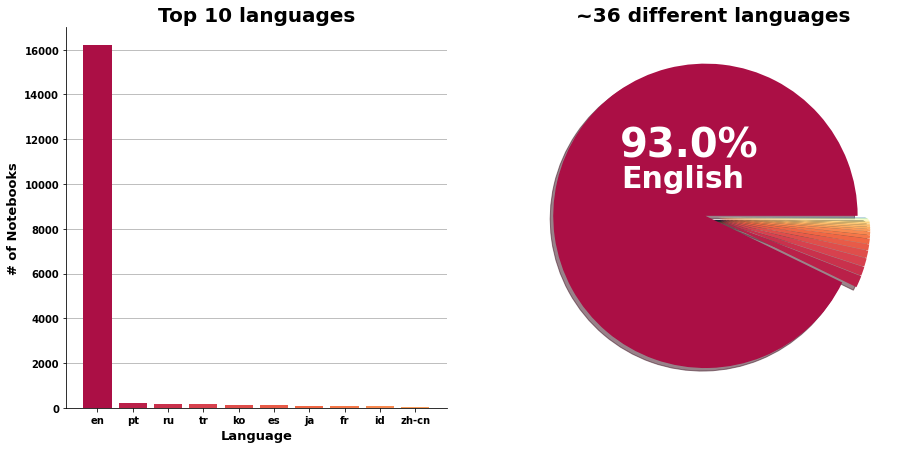

In [26]:
colors = sns.color_palette("Spectral", n_colors=len(df_lang))

dt = df_lang.sort_values("Count", ascending=False)

fig, axs = plt.subplots(1, 2, figsize=(15, 7))

explode = np.flip(np.linspace(0, 0.05, len(df_lang)))

axs[1].pie(dt.Count, colors=colors, explode=explode, shadow=True);

top = np.round(dt.Count.en / dt.Count.sum(), 2) * 100
axs[1].text(-0.61, 0.40, f"{top}%", size=40, c="white")
axs[1].text(-0.6, 0.2, f"English", size=30, c="white")
axs[1].set_title(f"~{len(df_lang)} different languages", size=20)

axs[0].grid(True, axis="y", zorder=0)
axs[0].bar(df_lang.sort_values("Count", ascending=False).head(10).index, 
           df_lang.sort_values("Count", ascending=False).head(10).Count, color=colors[:10], zorder=3)

axs[0].set_title("Top 10 languages", size=20)
axs[0].set_ylabel("# of Notebooks", size=13, weight="bold")
axs[0].set_xlabel("Language", size=13, weight="bold");

<div class="alert alert-block alert-info">
<b>Note:</b> A fairly basic approach to language detection is used, which probably resulted in a few incorrect identifications. The actual number of different languages is lower than 35. </div>

In [28]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")